In [550]:
import mltrainer
assert mltrainer.__version__ >= "0.2.5"

In [551]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

import torch.nn.functional as F

In [552]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [553]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [554]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

(Heartdataset (len 87554), Heartdataset (len 21892))

In [555]:
from torch.utils.data import random_split

# Bepaal verhouding, bijvoorbeeld 80% train / 20% val
total_len = len(traindataset)
val_len = int(0.2 * total_len)
train_len = total_len - val_len

traindataset, valdataset = random_split(traindataset, [train_len, val_len])

In [556]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
valstreamer = BaseDatastreamer(valdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer), len (valstreamer)


(2188, 684, 547)

In [557]:
x, y = next(trainstreamer.stream())
x.shape

torch.Size([32, 192, 1])

In [558]:
from collections import Counter

labels = [int(y) for _, y in traindataset]  # of trainstreamer.ds
label_counts = Counter(labels)
print(label_counts)

Counter({0: 57885, 4: 5174, 2: 4671, 1: 1781, 3: 533})


In [559]:
total = sum(label_counts.values())
num_classes = 5

class_weights = [total / label_counts.get(i, 1) for i in range(num_classes)]
class_weights_tensor = torch.FloatTensor(class_weights)

print("Class weights:", class_weights_tensor)

Class weights: tensor([  1.2101,  39.3285,  14.9955, 131.4146,  13.5377])


In [560]:
x = x.permute(0, 2, 1)  # (32, 1, 187) voor Conv1d

x.shape


torch.Size([32, 1, 192])

In [561]:
class TinyECGCNN(nn.Module):
    def __init__(self, num_classes=5, filters=16, hidden_units=64, input_size=192, dropout=0.2):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, filters, kernel_size=5, padding=2),
            nn.BatchNorm1d(filters),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),

            nn.Conv1d(filters, filters * 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(filters * 2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
        )

        self.flatten_dim = filters * (input_size // 2)  # 192 → 96 na pooling

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [562]:
class ECGWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        # x van vorm (batch, 187, 1) → (batch, 1, 187)
        x = x.permute(0, 2, 1)
        return self.base_model(x)

In [563]:
model = TinyECGCNN()
yhat = model(x)
yhat.shape

torch.Size([32, 5])

In [564]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()
metrics_list = [f1micro, f1macro, precision, recall, accuracy]

In [565]:
for metric in metrics_list:
    print(f"{metric}:", metric(y, yhat))

F1Score_micro: 0.0
F1Score_macro: 0.0
Precision_micro: 0.0
Recall_macro: 0.0
Accuracy: 0.0


In [566]:
from mltrainer import ReportTypes, Trainer, TrainerSettings

# model = TinyECGCNN()
model = ECGWrapper(TinyECGCNN())
optimizer = torch.optim.Adam
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

steps = len(trainstreamer) // 5

settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy, f1micro, f1macro, precision, recall],
    logdir="logs/heart1D",
    train_steps=steps,
    valid_steps=steps,
    reporttypes=[ReportTypes.TENSORBOARD],
    scheduler_kwargs=None,
    earlystop_kwargs=None
    )

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optimizer,
    traindataloader=trainstreamer.stream(),
    validdataloader=teststreamer.stream(),
    scheduler=None,
    )

trainer.loop()

2025-06-11 21:06:55.738 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart1D/20250611-210655
100%|██████████| 437/437 [00:03<00:00, 117.23it/s]
2025-06-11 21:07:03.275 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.7243 test 0.4900 metric ['0.7645', '0.7645', '0.5221', '0.7645', '0.8282']
100%|██████████| 437/437 [00:04<00:00, 90.10it/s]
2025-06-11 21:07:11.892 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.5137 test 0.4224 metric ['0.8510', '0.8510', '0.6087', '0.8510', '0.8645']
100%|██████████| 437/437 [00:03<00:00, 118.76it/s]
2025-06-11 21:07:20.739 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4883 test 0.4116 metric ['0.8942', '0.8942', '0.6699', '0.8942', '0.8837']
100%|██████████| 437/437 [00:03<00:00, 117.50it/s]
2025-06-11 21:07:28.318 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.4145 test 0.4175 metric ['0.8069', '0.8069', '0.5578', '0.8069', '0.8614']
100%|██████████| 437/437 [00:04<00:00, 108.

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

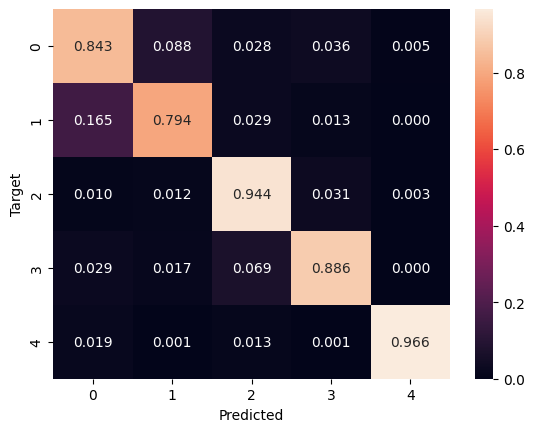

In [567]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()

for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")